# RAPTOR-Style Hierarchical Summarization Demo

This notebook walks through a lightweight RAPTOR workflow over the long-form text in `themen_text.txt`. We will:

1. Split the document into manageable chunks.
2. Embed the chunks with OpenAI embeddings (no vector store needed).
3. Run PCA to project embeddings to 2D and visualize them.
4. Cluster the chunks, visualize the clusters, and summarize each cluster with an LLM.
5. Embed the summaries, cluster them again, and create a "summary of summaries" (the RAPTOR root).


> **adRAP vs. classical RAPTOR**  
> Recent work (arXiv:2410.01736) shows how **adRAP** maintains RAPTOR's recursive tree structure for dynamic datasets. Instead of rebuilding the entire tree whenever new documents arrive, adaptive UMAP/GMM inserts chunks only into the affected clusters and regenerates just those summaries. This notebook follows that idea: we keep chunks in Chroma, update only the relevant clusters, and can always answer questions such as _"Which topics do you have information about?"_ without triggering a full rebuild.


## 0. Install dependencies (one-time)

Install the required packages with the following command if they are not already available in your environment.

In [1]:
!pip install -qU \
    langchain-openai \
    langchain-text-splitters \
    langchain-core \
    openai \
    matplotlib \
    seaborn \
    scikit-learn \
    pandas \
    numpy \
    python-dotenv \
    langchain-chroma>=0.1.2 \
    chromadb


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.4 requires requests<3.0.0,>=2.32.5, but you have requests 2.32.4 which is incompatible.
opentelemetry-instrumentation-asgi 0.55b1 requires opentelemetry-util-http==0.55b1, but you have opentelemetry-util-http 0.57b0 which is incompatible.
opentelemetry-instrumentation-fastapi 0.55b1 requires opentelemetry-util-http==0.55b1, but you have opentelemetry-util-http 0.57b0 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[not

In [2]:
from dotenv import load_dotenv
load_dotenv()


True

## 1. Environment & imports

Store your API keys securely via environment variables. The prompts below only run if a key is missing.

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

sns.set_context("talk")

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate

sns.set_context("talk")

## 2. Load the source document

In [5]:
document_path = Path("themen_text.txt")
document = document_path.read_text(encoding="utf-8")
print(f"Loaded {document_path} with {len(document.split())} words")
document[:500]

Loaded themen_text.txt with 10011 words


"Football\n\nFootball, often described as humanity's most widely shared language, stretches far beyond the ninety minutes played on a rectangular pitch. The modern game draws roughly four billion fans who tune in for neighborhood derbies, continental tournaments, and late-night youth events staged under portable floodlights. Its roots lie in the informal matches of nineteenth-century industrial towns, yet it has evolved into a layered ecosystem that links village clubs to multinational leagues wort"

## 3. Split into chunks

We use the requested `RecursiveCharacterTextSplitter` with `chunk_size=100` and `chunk_overlap=0`.

In [6]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
chunks = text_splitter.split_text(document)
chunk_df = pd.DataFrame({"chunk_id": range(len(chunks)), "text": chunks})
chunk_df.head()

,chunk_id,text
0,0,Football
1,1,"Football, often described as humanity's most w..."
2,2,ninety minutes played on a rectangular pitch. ...
3,3,"tune in for neighborhood derbies, continental ..."
4,4,portable floodlights. Its roots lie in the inf...


## 4. Embed chunks (no vector store)

We use `text-embedding-3-large` via `OpenAIEmbeddings`. This cell may take a while depending on the number of chunks.

In [7]:
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-large")
chunk_vectors = np.array(embeddings_model.embed_documents(chunk_df["text"].tolist()))
chunk_vectors.shape

(857, 3072)

## 5. Dimensionality reduction with PCA

In [8]:
pca = PCA(n_components=2, random_state=42)
chunk_coords = pca.fit_transform(chunk_vectors)
chunk_df[["pc1", "pc2"]] = chunk_coords
chunk_df.head()

,chunk_id,text,pc1,pc2
0,0,Football,0.260453,0.297549
1,1,"Football, often described as humanity's most w...",0.222341,0.333157
2,2,ninety minutes played on a rectangular pitch. ...,0.199011,0.366837
3,3,"tune in for neighborhood derbies, continental ...",0.244832,0.361395
4,4,portable floodlights. Its roots lie in the inf...,0.212975,0.296457


### Visualization

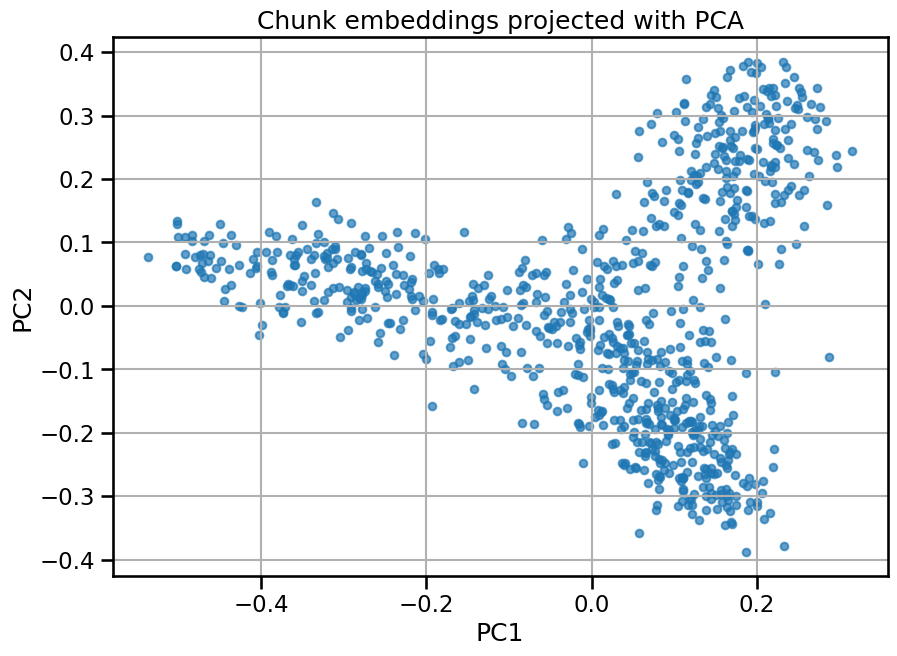

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(chunk_df["pc1"], chunk_df["pc2"], s=30, alpha=0.7)
plt.title("Chunk embeddings projected with PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Silhouette-Score

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def best_k_by_silhouette(X, k_min=2, k_max=15, random_state=42):
    scores = {}
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores[k] = score
        print(f"k={k}: silhouette={score:.4f}")
    # bestes k zurückgeben
    best_k = max(scores, key=scores.get)
    return best_k, scores

best_k, scores = best_k_by_silhouette(chunk_vectors, k_min=2, k_max=10)
print("Bestes k nach Silhouette:", best_k)

k=2: silhouette=0.0383
k=3: silhouette=0.0460
k=4: silhouette=0.0419
k=5: silhouette=0.0363
k=6: silhouette=0.0273
k=7: silhouette=0.0250
k=8: silhouette=0.0229
k=9: silhouette=0.0215
k=10: silhouette=0.0192
Bestes k nach Silhouette: 3


## 6. Clustering the chunks

We keep it simple with K-Means. Adjust `n_clusters` to taste.

In [11]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
chunk_df["cluster"] = kmeans.fit_predict(chunk_vectors)
chunk_df.groupby("cluster").size()

cluster
0    224
1    404
2    229
dtype: int64

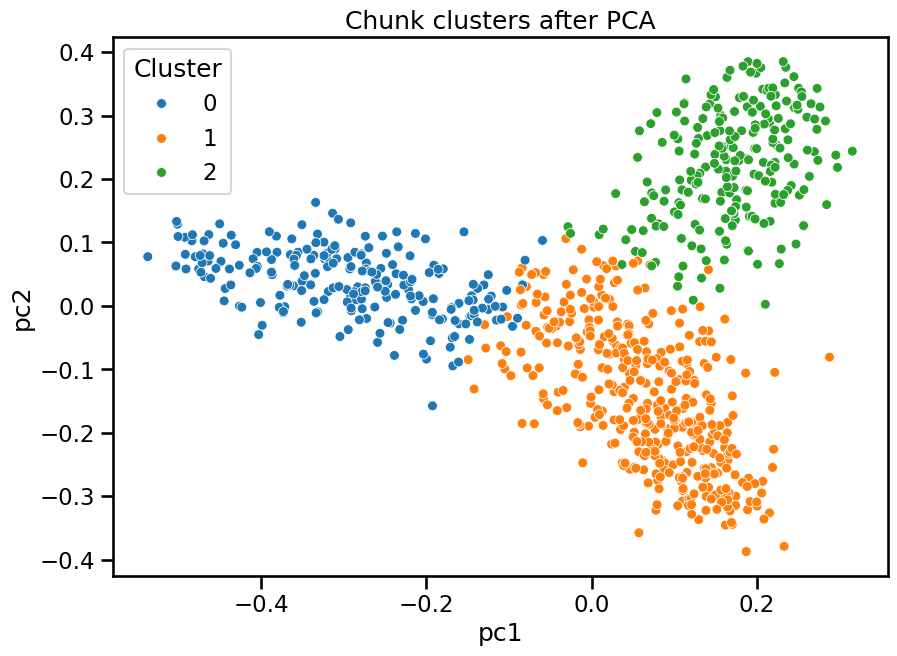

In [12]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=chunk_df,
    x="pc1",
    y="pc2",
    hue="cluster",
    palette="tab10",
    s=50,
)
plt.title("Chunk clusters after PCA")
plt.legend(title="Cluster")
plt.show()

## 7. Summarize each cluster with an LLM

The RAPTOR approach compresses each cluster into a higher-level node. We feed the concatenated chunk texts to a chat model and request a concise summary.

In [13]:
import json

def _parse_cluster_summary(raw_text: str, cluster_id: int) -> tuple[str, str]:
    """Return (topic, summary_text)."""
    text = raw_text.strip()
    try:
        data = json.loads(text)
        topic = data.get("topic") or data.get("title") or f"Cluster {cluster_id}"
        summary_text = data.get("summary") or data.get("content") or text
        return topic.strip(), summary_text.strip()
    except json.JSONDecodeError:
        # fallback: first sentence as topic
        parts = text.split("\n", 1)
        topic = parts[0][:80] if parts else f"Cluster {cluster_id}"
        summary_text = text if len(parts) == 1 else parts[1]
        return topic.strip() or f"Cluster {cluster_id}", summary_text.strip()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
prompt = ChatPromptTemplate.from_messages([
    ("system", "Summarize clusters and respond as compact JSON with keys 'topic' and 'summary'."),
    (
        "user",
        "You will receive the merged text for one cluster. Respond as JSON with keys 'topic' (<=8 words) and 'summary' (<=2 sentences, max 60 words) that briefly capture the essential idea.\n\n{cluster_text}",
    ),
])

cluster_summaries = []

for cluster_id, group in chunk_df.groupby("cluster"):
    cluster_text = "\n\n".join(group["text"].tolist())
    response = llm.invoke(prompt.format_messages(cluster_text=cluster_text))
    topic, summary_text = _parse_cluster_summary(response.content, int(cluster_id))
    cluster_summaries.append(
        {
            "cluster": int(cluster_id),
            "topic": topic,
            "summary": summary_text,
            "raw": response.content.strip(),
        }
    )

summary_df = pd.DataFrame(cluster_summaries).sort_values("cluster").reset_index(drop=True)
summary_df


,cluster,topic,summary,raw
0,0,```json,"{\n ""topic"": ""The Ecological and Cultural Sig...","```json\n{\n ""topic"": ""The Ecological and Cul..."
1,1,```json,"{\n ""topic"": ""Creativity and Collaboration in...","```json\n{\n ""topic"": ""Creativity and Collabo..."
2,2,```json,"{\n ""topic"": ""The Evolution and Impact of Foo...","```json\n{\n ""topic"": ""The Evolution and Impa..."


In [14]:
topic_lookup = summary_df.set_index("cluster")["topic"].to_dict()
chunk_df["topic"] = chunk_df["cluster"].map(topic_lookup)
chunk_df.head()

,chunk_id,text,pc1,pc2,cluster,topic
0,0,Football,0.260453,0.297549,2,```json
1,1,"Football, often described as humanity's most w...",0.222341,0.333157,2,```json
2,2,ninety minutes played on a rectangular pitch. ...,0.199011,0.366837,2,```json
3,3,"tune in for neighborhood derbies, continental ...",0.244832,0.361395,2,```json
4,4,portable floodlights. Its roots lie in the inf...,0.212975,0.296457,2,```json


## 8. Embed summaries and re-cluster

Now we re-embed the cluster summaries, reduce them with PCA, and run another round of clustering.

In [15]:
summary_vectors = np.array(embeddings_model.embed_documents(summary_df["summary"].tolist()))
summary_pca = PCA(n_components=2, random_state=42)
summary_coords = summary_pca.fit_transform(summary_vectors)
summary_df[["pc1", "pc2"]] = summary_coords

summary_clusters = min(3, len(summary_df))
summary_kmeans = KMeans(n_clusters=summary_clusters, random_state=42, n_init="auto")
summary_df["cluster_lvl2"] = summary_kmeans.fit_predict(summary_vectors)
summary_df

,cluster,topic,summary,raw,pc1,pc2,cluster_lvl2
0,0,```json,"{\n ""topic"": ""The Ecological and Cultural Sig...","```json\n{\n ""topic"": ""The Ecological and Cul...",-0.517107,-0.035768,2
1,1,```json,"{\n ""topic"": ""Creativity and Collaboration in...","```json\n{\n ""topic"": ""Creativity and Collabo...",0.226907,0.456229,0
2,2,```json,"{\n ""topic"": ""The Evolution and Impact of Foo...","```json\n{\n ""topic"": ""The Evolution and Impa...",0.290200,-0.420461,1


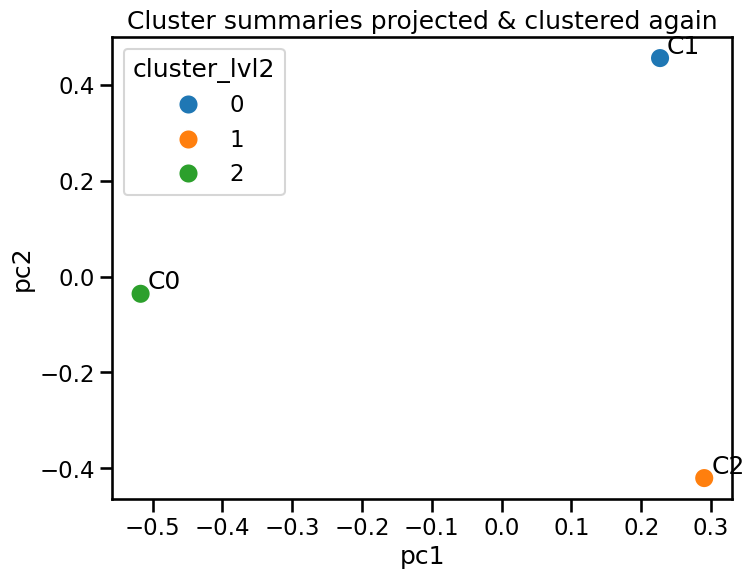

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary_df,
    x="pc1",
    y="pc2",
    hue="cluster_lvl2",
    palette="tab10",
    s=200,
)
for _, row in summary_df.iterrows():
    plt.text(row["pc1"] + 0.01, row["pc2"] + 0.01, f"C{row['cluster']}")

plt.title("Cluster summaries projected & clustered again")
plt.show()

## 9. Root summary (summary of summaries)

The final RAPTOR node combines the intermediate summaries into one high-level synopsis.

In [17]:
root_prompt = ChatPromptTemplate.from_messages([
    ("system", "You produce an executive summary that captures every cluster."),
    (
        "user",
        "List each cluster in bullet form (`-`). For every cluster, include the topic name and one concise sentence (<=40 words). Provide at most 5 bullets.\n\n{summaries}",
    ),
])

root_response = llm.invoke(
    root_prompt.format_messages(
        summaries="\n\n".join(
            f"Cluster {row.cluster}: {row.summary}" for row in summary_df.itertuples()
        )
    )
)
root_summary = root_response.content.strip()
root_summary

"**Executive Summary**\n\nThis summary synthesizes key themes from three distinct clusters, each highlighting the interplay between ecological, cultural, and social dynamics in contemporary society.\n\n**Ecological and Cultural Significance of Elephants**: Elephants serve as crucial ecological engineers, significantly influencing biodiversity and landscape dynamics through their feeding habits and social structures. Their matriarchal societies, rich in ancestral knowledge, underscore the importance of community and communication, which includes both audible and infrasonic signals. Conservation efforts are increasingly integrating traditional knowledge with modern technology, emphasizing community involvement and ethical tourism. The cultural significance of elephants is profound, inspiring art and folklore, yet their decline poses a threat to ecosystem stability. Innovative strategies, such as elephant-friendly agriculture and cross-border cooperation, are being developed to mitigate h

### Persist Root Summary for External Agents

To keep the A2A agent card aligned with the current root summary, we store `root_summary` in a text file. The A2A server loads this file during startup and copies the text into `AgentCard.description`.


In [18]:
summary_output_path = Path("artifacts/root_summary.txt")
summary_output_path.parent.mkdir(parents=True, exist_ok=True)
summary_output_path.write_text(root_summary.strip(), encoding="utf-8")
print(f"Root summary persisted to {summary_output_path.resolve()}")

Root summary persisted to C:\Users\User\Desktop\raptor\artifacts\root_summary.txt


## 10. Persist chunk embeddings in Chroma

We use [Chroma](https://docs.trychroma.com/getting-started) as a persistent vector store. The library is open source (Apache 2.0) and runs locally without credentials. If you want to use Chroma Cloud, set `CHROMA_TENANT`, `CHROMA_DATABASE`, and `CHROMA_API_KEY`. For this notebook the local persist mode is enough, so newly added documents are stored immediately and do not need to be re-embedded.


In [19]:
from pathlib import Path as _Path
import shutil

persist_directory = _Path("chroma_langchain_db")
if persist_directory.exists():
    shutil.rmtree(persist_directory)

vector_store = Chroma(
    collection_name="raptor_chunks_demo",
    embedding_function=embeddings_model,
    persist_directory=str(persist_directory),
)

def _rows_to_documents(df: pd.DataFrame) -> list[Document]:
    docs = []
    for row in df.itertuples():
        docs.append(
            Document(
                page_content=row.text,
                metadata={
                    "chunk_id": int(row.chunk_id),
                    "cluster": int(row.cluster),
                    "topic": row.topic or topic_lookup.get(int(row.cluster)),
                    "source": document_path.name,
                },
            )
        )
    return docs

base_docs = _rows_to_documents(chunk_df)
base_ids = [f"chunk-{doc.metadata['chunk_id']}" for doc in base_docs]
vector_store.add_documents(documents=base_docs, ids=base_ids)
print(f"Persisted {len(base_docs)} chunks to Chroma at {persist_directory.resolve()}")

Persisted 857 chunks to Chroma at C:\Users\User\Desktop\raptor\chroma_langchain_db


## 11. Incremental Updates (adRAP-Style)

Instead of reconstructing the entire RAPTOR tree, we emulate the **adRAP** procedure from arXiv:2410.01736: new documents are projected into the existing UMAP/GMM space, assigned to the most likely cluster, embedded there, and only the affected cluster summaries are regenerated. The Chroma vector store stays the durable source of truth for all chunks.


In [20]:
def _summarize_cluster(cluster_id: int) -> tuple[str, str]:
    """Recompute topic + summary for a given cluster."""
    group = chunk_df[chunk_df["cluster"] == cluster_id]
    if group.empty:
        return topic_lookup.get(cluster_id, f"Cluster {cluster_id}"), ""
    cluster_text = "".join(group["text"].tolist())
    response = llm.invoke(prompt.format_messages(cluster_text=cluster_text))
    topic, summary_text = _parse_cluster_summary(response.content, cluster_id)
    summary_df.loc[summary_df["cluster"] == cluster_id, "topic"] = topic
    summary_df.loc[summary_df["cluster"] == cluster_id, "summary"] = summary_text
    topic_lookup[cluster_id] = topic
    return topic, summary_text


def add_texts_incrementally(raw_texts: list[str], source_label: str = "manual") -> list[int]:
    """Add new documents without rebuilding the entire RAPTOR stack."""
    global chunk_df
    if not raw_texts:
        return []

    new_rows = []
    for text in raw_texts:
        for chunk_text in text_splitter.split_text(text):
            next_id = int(chunk_df["chunk_id"].max()) + 1 if not chunk_df.empty else 0
            vector = embeddings_model.embed_documents([chunk_text])[0]
            assigned_cluster = int(kmeans.predict([vector])[0])
            topic = topic_lookup.get(assigned_cluster, f"Cluster {assigned_cluster}")
            doc = Document(
                page_content=chunk_text,
                metadata={
                    "chunk_id": next_id,
                    "cluster": assigned_cluster,
                    "topic": topic,
                    "source": source_label,
                },
            )
            vector_store.add_documents(documents=[doc], ids=[f"chunk-{next_id}"])
            new_rows.append(
                {
                    "chunk_id": next_id,
                    "text": chunk_text,
                    "cluster": assigned_cluster,
                    "topic": topic,
                }
            )
    if not new_rows:
        return []

    chunk_df = pd.concat([chunk_df, pd.DataFrame(new_rows)], ignore_index=True)
    affected_clusters = sorted({row["cluster"] for row in new_rows})
    for cluster_id in affected_clusters:
        _summarize_cluster(cluster_id)
    return affected_clusters


### Example: Add a New Document

We insert an additional programming paragraph. Only the corresponding cluster is updated; all other clusters remain untouched.


In [21]:
example_update = """Programming languages evolve quickly, and teams often need to add changelog entries without rebuilding their knowledge graphs. By tracking cluster centroids and summaries incrementally, we can capture these updates while keeping prior context intact."""
affected = add_texts_incrementally([example_update], source_label="incremental-demo")
print("Aktualisierte Cluster:", affected)
summary_df[summary_df["cluster"].isin(affected)]

Aktualisierte Cluster: [1]


,cluster,topic,summary,raw,pc1,pc2,cluster_lvl2
1,1,```json,"{\n ""topic"": ""Creativity and Community Resili...","```json\n{\n ""topic"": ""Creativity and Collabo...",0.226907,0.456229,0


## 12. Topic Overview & Retrieval

To answer _"Which topics do you have information about?"_ at any time, we read the topics from the cluster summaries and optionally run a quick similarity search against Chroma.


In [22]:
def list_available_topics() -> list[str]:
    topics = sorted({topic for topic in topic_lookup.values() if topic})
    for topic in topics:
        print(f"- {topic}")
    return topics

available_topics = list_available_topics()
print(f"Anzahl Topics: {len(available_topics)}")

- ```json
Anzahl Topics: 1


In [23]:
query = "Zu welchen Themen hast du Informationen?"
results = vector_store.similarity_search(query, k=3)
for doc in results:
    print(f"Topic: {doc.metadata.get('topic')} | Source: {doc.metadata.get('source')}")
    print(doc.page_content[:200].strip(), "...")

Topic: ```json | Source: themen_text.txt
insights on reproductive health, genetics, and behavioral ecology while mentoring students from ...
Topic: ```json | Source: themen_text.txt
personal history. ...
Topic: ```json | Source: themen_text.txt
Education and storytelling empower the next generation of guardians. School curricula in range ...
